## Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision

import imageio as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from modules_v4 import UNet_conditional
from P1_CustomDataset import P1_CustomDataset
from P1_CombinedDataset import P1_CombinedDataset

packages during training

## Hyperparameters

In [2]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Define Custom Dataset

training dataset的mean & std

In [3]:
train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]

建train transform和val transform

val transform和test transform一樣

In [4]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

用P1_CustomDataset分別產生兩個資料集的train dataset，再將兩個dataset合成一個dataset，並產生trainloader

In [5]:
train_dataset_MNISTM = P1_CustomDataset(csv_file='../hw2_data/digits/mnistm/train.csv', root_dir='../hw2_data/digits/mnistm/data', transform=transform_train)
train_dataset_SVHN = P1_CustomDataset(csv_file='../hw2_data/digits/svhn/train.csv', root_dir='../hw2_data/digits/svhn/data', transform=transform_train)
combined_dataset = P1_CombinedDataset(train_dataset_MNISTM, train_dataset_SVHN)

combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(combined_loader))

1059


In [6]:
# print shape
image_first_batch, label_first_batch = next(iter(combined_loader))  #get first batch's image & mask
label_dataset, label_image = label_first_batch
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_dataset.shape: ", label_dataset.shape)
print("label_image.shape: ", label_image.shape)
# get some values
print("normalized pixel value:", image_first_batch[3][0][9][8])
print("label_dataset (should be integer 0 ~ 1):",label_dataset[3])
print("label_image (should be integer 0 ~ 9):",label_image[3])

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([128, 3, 28, 28])
type(label_first_batch):  <class 'list'>
label_dataset.shape:  torch.Size([128])
label_image.shape:  torch.Size([128])
normalized pixel value: tensor(-0.4980)
label_dataset (should be integer 0 ~ 1): tensor(0)
label_image (should be integer 0 ~ 9): tensor(8)


In [7]:
print("dataset label of first batch:", label_dataset) # two datasets are mixed together

dataset label of first batch: tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label of dataset: tensor(1)
label of image: tensor(9)
shape:  (28, 28, 3)


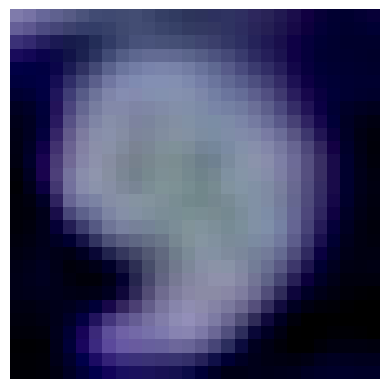

In [8]:
# visualize with normalization
idx = 0
first_image = image_first_batch[idx]
first_label_dataset = label_dataset[idx]
first_label_image = label_image[idx]
print("label of dataset:",first_label_dataset)
print("label of image:",first_label_image)

# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

print("shape: ",image_np.shape) # need to convert back to 28*28 during inference (in digit_classifier.py)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Build Model

instance model and put it on device

In [10]:
net = UNet_conditional(size=28, time_dim=256, num_classes=20, device=device).to(device)

In [14]:
#print output shape
x = torch.randn(10,3,28,28).to(device) # dummy input也放到device
t = torch.randint(0, 500, (10,)).to(device)  # Ensure values are in range [0, 9]
y = torch.randint(0, 20, (10,)).to(device)
#dataset_label = torch.randint(0, 2, (10,)).to(device)
output = net(x, t, y)
print(output.shape)
print(x.dtype)
print(y.dtype)

torch.Size([10, 3, 28, 28])
torch.float32
torch.int64


## Training

Loss and Optimizer and epoch_n

In [11]:
# number of epoch
num_epochs = 100
# DDPM paper suggest using MSE as noise loss
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Different base learning rate and update strategy #!!!!!!
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(combined_loader), eta_min = 0) # update lr each batch

# total time steps
T = 400


#### DDPM training functions

alpha_t and alpha_hat_t of DDPM

In [12]:
# 1. beta
def beta_scheduler(n_timestep=400, linear_start=1e-4, linear_end=2e-2):
    betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    return betas
beta_1 = 1e-4
beta_T = 2e-2
beta = beta_scheduler(T, beta_1, beta_T) 
# 2. alpha
alpha = 1 - beta
# 3. alpha_hat
# alpha hat = [alpha[0], alpha[0]*alpha[1], alpha[0]*alpha[1]*alpha[2], ... ,alpha[0]*...*alpha[T-1])] 
alpha_hat = torch.zeros_like(alpha) # tensor with len T, alpha_hat.shape = T
alpha_hat[0] = alpha[0] # Set the first element
for i in range(1, alpha.shape[0]):
    alpha_hat[i] = alpha_hat[i - 1] * alpha[i]


torch.save(beta, './alpha_tensors/beta_tensor.pt')
torch.save(alpha, './alpha_tensors/alpha_tensor.pt')
torch.save(alpha_hat, './alpha_tensors/alpha_hat_tensor.pt')

functions

In [13]:
def noise_x_t(alpha_hat, x_0, t, epsilon):
    """given x[0](origin image) and t, return x[t](noisy image from x[0] by adding epsilon repeatly t times)"""
    """一步登天"""
    """epsilon.shape = x_0.shape = N*C*H*W,  t.shape = N"""
    """alpha_hat.shape = T, index t = 0 ~ T-1"""

    sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_alpha_hat.shape = N*1*1*1
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_one_minus_alpha_hat.shape = N*1*1*1

    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * epsilon
    
    return x_t #x[t] is N*C*H*W

#### training loop (DDPM framework)

In [18]:
# Training Loop
model_version = 4    # version 4: combined 2 datasets to 1 dataset + change model + T = 400
training_version = 1 # for name of checkpoint model # train的第幾次

train_loss_list = []
save_model_loss_list = []
lr_list = []

beta = beta.to(device)
alpha = alpha.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, label_dataset_image in tqdm(combined_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        # ========================================================== step1: x0 ~ q(x0) ===========================================================
        # x0 is original image: images
        dataset_label = label_dataset_image[0]
        image_label = label_dataset_image[1]
        images, dataset_label, image_label = images.to(device), dataset_label.to(device), image_label.to(device)# model, input output of model are moved to GPU during training
        N, C, H, W = images.shape[0], images.shape[1], images.shape[2], images.shape[3]

        # ==================================================== step2: t ~ Uniform({1,...,T}) =====================================================
        t_np = np.random.randint(0, T, size=(N,))  # Sample t from Uniform({0, ..., T-1}) # python is 0-indexing
        t = torch.from_numpy(t_np)
        t = t.to(device)

        # ======================================================= step3: epsilon ~ N(0, 1) =======================================================
        noise = torch.randn(N, C, H, W)  # Sample noise from normal distribution with mean 0 and standard deviation 1
        noise = noise.to(device)         # dtype = float32     # shape = N* C* H* W

        # ===================================== step4: take gradient descent step on noise and predict_noise =====================================
        x_t = noise_x_t(alpha_hat=alpha_hat, x_0=images, t=t, epsilon=noise)
        x_t = x_t.to(device)
        
        #predict_noise=N*C*H*W
        # version 4: combined 2 datasets to 1 dataset
        image_label = image_label + 10 * dataset_label
        image_label = image_label.to(device)
        
        if torch.rand(1).item() < 0.1:  # 10% chance to enter this block # 10% of training is unconditional training
            image_label = None 
        predict_noise = net(x=x_t, t=t, y=image_label) #x=N*C*H*W, t=N, y=N, 

        loss = criterion(noise, predict_noise) # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        scheduler.step() # update lr each batch(cosine scheduler)
        


    train_loss /= len(combined_loader)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}')
    print(f'Learning rate {scheduler.get_last_lr()[0]}')
    train_loss_list.append(train_loss)

    #scheduler.step() # update lr each epoch(linear step scheduler)
    lr_list.append(scheduler.get_last_lr()[0])

    if epoch % 15 == 0:
        # save the model state_dict
        save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth')
        torch.save(net.state_dict(), save_dir)
        save_model_loss_list.append([f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth' ,train_loss])
        print(f'Saved model to {save_dir}. Training loss = {train_loss}')

# save the model state_dict
save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}.pth')
torch.save(net.state_dict(), save_dir)
print(f'Saved model  to {save_dir}')

Epoch 1/100: 100%|██████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:50<00:00,  2.25batch/s]


Epoch 1/100 - Loss: 0.1046
Learning rate 9.997532801828645e-05
Saved model to ../checkpoint_model/P1/P1_model_ver4_1_epoch0.pth. Training loss = 0.10460896769624707


Epoch 2/100: 100%|██████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 2/100 - Loss: 0.0529
Learning rate 9.990133642141334e-05


Epoch 3/100: 100%|██████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 3/100 - Loss: 0.0449
Learning rate 9.977809823015401e-05


Epoch 4/100: 100%|██████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 4/100 - Loss: 0.0417
Learning rate 9.960573506572376e-05


Epoch 5/100:  32%|██████████████████████████▉                                                        | 343/1059 [02:33<05:18,  2.25batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 67/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 67/100 - Loss: 0.0292
Learning rate 2.4547929212481114e-05


Epoch 68/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 68/100 - Loss: 0.0290
Learning rate 2.3208660251049897e-05


Epoch 69/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 69/100 - Loss: 0.0292
Learning rate 2.18958311073933e-05


Epoch 70/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 70/100 - Loss: 0.0292
Learning rate 2.0610737385376146e-05


Epoch 71/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 71/100 - Loss: 0.0289
Learning rate 1.9354647317350954e-05


Epoch 72/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 72/100 - Loss: 0.0291
Learning rate 1.8128800512565273e-05


Epoch 73/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 73/100 - Loss: 0.0292
Learning rate 1.6934406733817214e-05


Epoch 74/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 74/100 - Loss: 0.0288
Learning rate 1.577264470356537e-05


Epoch 75/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 75/100 - Loss: 0.0293
Learning rate 1.4644660940672446e-05


Epoch 76/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.25batch/s]


Epoch 76/100 - Loss: 0.0290
Learning rate 1.3551568628929266e-05
Saved model to ../checkpoint_model/P1/P1_model_ver4_1_epoch75.pth. Training loss = 0.029009185555523807


Epoch 77/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 77/100 - Loss: 0.0288
Learning rate 1.2494446518476881e-05


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 78/100 - Loss: 0.0288
Learning rate 1.1474337861210382e-05


Epoch 79/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 79/100 - Loss: 0.0290
Learning rate 1.049224938121531e-05


Epoch 80/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 80/100 - Loss: 0.0291
Learning rate 9.549150281252484e-06


Epoch 81/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.25batch/s]


Epoch 81/100 - Loss: 0.0288
Learning rate 8.645971286271734e-06


Epoch 82/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 82/100 - Loss: 0.0288
Learning rate 7.783603724899076e-06


Epoch 83/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 83/100 - Loss: 0.0286
Learning rate 6.962898649802666e-06


Epoch 84/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 84/100 - Loss: 0.0288
Learning rate 6.184665997806693e-06


Epoch 85/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 85/100 - Loss: 0.0289
Learning rate 5.449673790581504e-06


Epoch 86/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 86/100 - Loss: 0.0286
Learning rate 4.758647376698924e-06


Epoch 87/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 87/100 - Loss: 0.0285
Learning rate 4.112268715800864e-06


Epoch 88/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 88/100 - Loss: 0.0287
Learning rate 3.5111757055873655e-06


Epoch 89/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 89/100 - Loss: 0.0287
Learning rate 2.9559615522886714e-06


Epoch 90/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 90/100 - Loss: 0.0287
Learning rate 2.4471741852422725e-06


Epoch 91/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 91/100 - Loss: 0.0287
Learning rate 1.9853157161527943e-06
Saved model to ../checkpoint_model/P1/P1_model_ver4_1_epoch90.pth. Training loss = 0.028732461334189455


Epoch 92/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 92/100 - Loss: 0.0287
Learning rate 1.5708419435684051e-06


Epoch 93/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 93/100 - Loss: 0.0288
Learning rate 1.204161903062601e-06


Epoch 94/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 94/100 - Loss: 0.0286
Learning rate 8.856374635655465e-07


Epoch 95/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 95/100 - Loss: 0.0286
Learning rate 6.155829702430996e-07


Epoch 96/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:51<00:00,  2.24batch/s]


Epoch 96/100 - Loss: 0.0286
Learning rate 3.9426493427609954e-07


Epoch 97/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 97/100 - Loss: 0.0284
Learning rate 2.219017698459937e-07


Epoch 98/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 98/100 - Loss: 0.0288
Learning rate 9.866357858641907e-08


Epoch 99/100: 100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 99/100 - Loss: 0.0287
Learning rate 2.467198171341916e-08


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 100/100 - Loss: 0.0284
Learning rate 0.0
Saved model  to ../checkpoint_model/P1/P1_model_ver4_1.pth


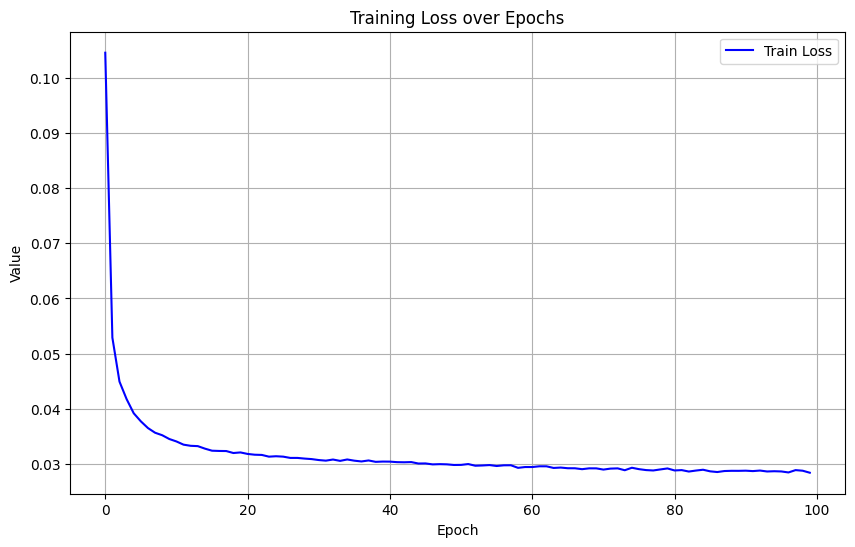

In [19]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')

# Adding titles and labels
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
# Show the plot
plt.show()

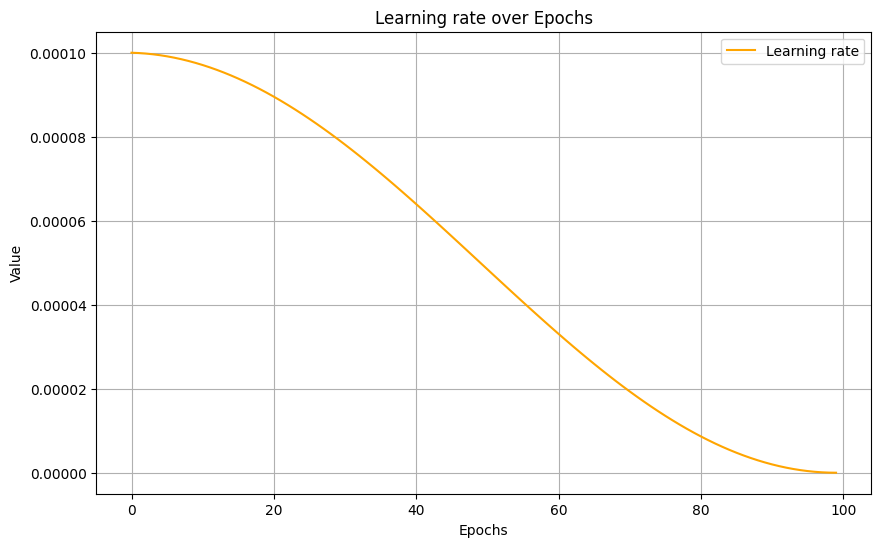

In [20]:
plt.figure(figsize=(10, 6))
# Plot Learning rate
plt.plot(lr_list, label='Learning rate', color='orange')


# Adding titles and labels
plt.title('Learning rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [21]:
print(train_loss_list)

[0.10460896769624707, 0.05288697439716378, 0.044902932275230865, 0.04172703655431358, 0.039156091678272, 0.03769085021044028, 0.03647036466226896, 0.035623663874576966, 0.03517072519940009, 0.03448241697386878, 0.034038747594858025, 0.03345646319965409, 0.03324931120012761, 0.033190817105196016, 0.03273633221996292, 0.03235955114939845, 0.032313815554616244, 0.03229829559333067, 0.031939794122117435, 0.03204629221989143, 0.031773265019389846, 0.031631188210349694, 0.03159237718095298, 0.03127935812988858, 0.031353898768553316, 0.031281229586985114, 0.03104923117810876, 0.031050182170145796, 0.030930150674904035, 0.030836080828887377, 0.030662208767405538, 0.030555447847586795, 0.030756485550835856, 0.03051363139011395, 0.030767507458895418, 0.030549126208475788, 0.03040715635378649, 0.030589294550382833, 0.03033699798797863, 0.030387650334519862, 0.030376069662816352, 0.03028234930724834, 0.03025900227623632, 0.03029375413575186, 0.030031809910456453, 0.030047426438196523, 0.0298754785

In [ ]:
for name, loss in save_model_loss_list:
    print(f"{name}:  {loss}")

### Train more epoch

In [25]:
model_path = '../checkpoint_model/P1/P1_model_ver4_1.pth'
net = UNet_conditional(size=28, time_dim=256, num_classes=20, device=device) # !!!!!!!!!! cpu, gpu !!!!!!!!!!
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) # !! cpu, gpu !!  #!!ver2 
net = net.to(device)

In [26]:
#print output shape
x = torch.randn(10,3,28,28).to(device) # dummy input也放到device
t = torch.randint(0, 500, (10,)).to(device)  # Ensure values are in range [0, 9]
y = torch.randint(0, 20, (10,)).to(device)
#dataset_label = torch.randint(0, 2, (10,)).to(device)
output = net(x, t, y)
print(output.shape)
print(x.dtype)
print(y.dtype)

torch.Size([10, 3, 28, 28])
torch.float32
torch.int64


In [27]:
# number of epoch
num_epochs = 100
num_epochs_addition = 40
# DDPM paper suggest using MSE as noise loss
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Different base learning rate and update strategy #!!!!!!
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs_addition * len(combined_loader), eta_min = 0) # update lr each batch


In [29]:
# Training Loop
model_version = 4    # version 4: combined 2 datasets to 1 dataset + change model + T = 400
training_version = 1 # for name of checkpoint model # train的第幾次

train_loss_list = []
save_model_loss_list = []
lr_list = []

beta = beta.to(device)
alpha = alpha.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(num_epochs, num_epochs+num_epochs_addition ):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, label_dataset_image in tqdm(combined_loader, desc=f'Epoch {epoch + 1}/{num_epochs + num_epochs_addition}', unit='batch'):  #進度條以batch完成度為趴數
        # ========================================================== step1: x0 ~ q(x0) ===========================================================
        # x0 is original image: images
        dataset_label = label_dataset_image[0]
        image_label = label_dataset_image[1]
        images, dataset_label, image_label = images.to(device), dataset_label.to(device), image_label.to(device)# model, input output of model are moved to GPU during training
        N, C, H, W = images.shape[0], images.shape[1], images.shape[2], images.shape[3]

        # ==================================================== step2: t ~ Uniform({1,...,T}) =====================================================
        t_np = np.random.randint(0, T, size=(N,))  # Sample t from Uniform({0, ..., T-1}) # python is 0-indexing
        t = torch.from_numpy(t_np)
        t = t.to(device)

        # ======================================================= step3: epsilon ~ N(0, 1) =======================================================
        noise = torch.randn(N, C, H, W)  # Sample noise from normal distribution with mean 0 and standard deviation 1
        noise = noise.to(device)         # dtype = float32     # shape = N* C* H* W

        # ===================================== step4: take gradient descent step on noise and predict_noise =====================================
        x_t = noise_x_t(alpha_hat=alpha_hat, x_0=images, t=t, epsilon=noise)
        x_t = x_t.to(device)
        
        #predict_noise=N*C*H*W
        # version 4: combined 2 datasets to 1 dataset
        image_label = image_label + 10 * dataset_label
        image_label = image_label.to(device)
        
        if torch.rand(1).item() < 0.1:  # 10% chance to enter this block # 10% of training is unconditional training
            image_label = None 
        predict_noise = net(x=x_t.float(), t=t, y=image_label) #x=N*C*H*W, t=N, y=N, 

        loss = criterion(noise, predict_noise) # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        scheduler.step() # update lr each batch(cosine scheduler)
        


    train_loss /= len(combined_loader)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}')
    print(f'Learning rate {scheduler.get_last_lr()[0]}')
    train_loss_list.append(train_loss)

    #scheduler.step() # update lr each epoch(linear step scheduler)
    lr_list.append(scheduler.get_last_lr()[0])

    if epoch % 15 == 0:
        # save the model state_dict
        save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth')
        torch.save(net.state_dict(), save_dir)
        save_model_loss_list.append([f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth' ,train_loss])
        print(f'Saved model to {save_dir}. Training loss = {train_loss}')

# save the model state_dict
save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}_epoch{epoch}.pth')
torch.save(net.state_dict(), save_dir)
print(f'Saved model  to {save_dir}')

Epoch 101/140: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:52<00:00,  2.24batch/s]


Epoch 101/100 - Loss: 0.0307
Learning rate 9.984586668665638e-05


Epoch 102/140: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 102/100 - Loss: 0.0304
Learning rate 9.938441702975674e-05


Epoch 104/140: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 104/100 - Loss: 0.0304
Learning rate 9.755282581475735e-05


Epoch 105/140: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 105/100 - Loss: 0.0303
Learning rate 9.619397662556421e-05


Epoch 106/140:  84%|███████████████████████████████████████████████████████████████████▊             | 887/1059 [06:37<01:17,  2.23batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 110/140: 100%|████████████████████████████████████████████████████████████████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 110/100 - Loss: 0.0302
Learning rate 8.535533905932653e-05


Epoch 111/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 111/100 - Loss: 0.0302
Learning rate 8.247240241650838e-05


Epoch 112/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 112/100 - Loss: 0.0298
Learning rate 7.938926261462294e-05


Epoch 113/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 113/100 - Loss: 0.0300
Learning rate 7.612492823579689e-05


Epoch 114/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 114/100 - Loss: 0.0297
Learning rate 7.26995249869766e-05


Epoch 115/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 115/100 - Loss: 0.0298
Learning rate 6.913417161825402e-05


Epoch 116/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 116/100 - Loss: 0.0297
Learning rate 6.545084971874687e-05


Epoch 117/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 117/100 - Loss: 0.0294
Learning rate 6.167226819279488e-05


Epoch 118/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 118/100 - Loss: 0.0295
Learning rate 5.78217232520111e-05


Epoch 119/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 119/100 - Loss: 0.0296
Learning rate 5.392295478639182e-05


Epoch 120/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 120/100 - Loss: 0.0295
Learning rate 4.999999999999961e-05


Epoch 121/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 121/100 - Loss: 0.0296
Learning rate 4.6077045213607326e-05
Saved model to ../checkpoint_model/P1/P1_model_ver4_1_epoch120.pth. Training loss = 0.02955268566849324


Epoch 122/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 122/100 - Loss: 0.0293
Learning rate 4.2178276747988114e-05


Epoch 123/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 123/100 - Loss: 0.0292
Learning rate 3.832773180720451e-05


Epoch 124/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 124/100 - Loss: 0.0291
Learning rate 3.454915028125244e-05


Epoch 125/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 125/100 - Loss: 0.0292
Learning rate 3.0865828381745364e-05


Epoch 126/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 126/100 - Loss: 0.0289
Learning rate 2.73004750130225e-05


Epoch 127/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 127/100 - Loss: 0.0289
Learning rate 2.387507176420241e-05


Epoch 128/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 128/100 - Loss: 0.0290
Learning rate 2.0610737385376183e-05


Epoch 129/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 129/100 - Loss: 0.0287
Learning rate 1.7527597583490656e-05


Epoch 130/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 130/100 - Loss: 0.0286
Learning rate 1.4644660940672519e-05


Epoch 131/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 131/100 - Loss: 0.0286
Learning rate 1.1979701719998369e-05


Epoch 132/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 132/100 - Loss: 0.0291
Learning rate 9.549150281252582e-06


Epoch 133/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 133/100 - Loss: 0.0287
Learning rate 7.367991782295358e-06


Epoch 134/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 134/100 - Loss: 0.0288
Learning rate 5.4496737905815945e-06


Epoch 135/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 135/100 - Loss: 0.0285
Learning rate 3.8060233744356468e-06


Epoch 136/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 136/100 - Loss: 0.0286
Learning rate 2.4471741852423085e-06
Saved model to ../checkpoint_model/P1/P1_model_ver4_1_epoch135.pth. Training loss = 0.028554310622019123


Epoch 137/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 137/100 - Loss: 0.0283
Learning rate 1.3815039801161651e-06


Epoch 138/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 138/100 - Loss: 0.0286
Learning rate 6.155829702431132e-07


Epoch 139/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 139/100 - Loss: 0.0283
Learning rate 1.5413331334360145e-07


Epoch 140/140: 100%|█████████████████████| 1059/1059 [07:54<00:00,  2.23batch/s]


Epoch 140/100 - Loss: 0.0285
Learning rate 0.0
Saved model  to ../checkpoint_model/P1/P1_model_ver4_1_epoch139.pth


In [32]:
print(train_loss_list)
for name, loss in save_model_loss_list:
    print(f"{name}:  {loss}")

[0.030727444577177705, 0.030419788477244074, 0.030324504563868104, 0.03036084766935019, 0.03030317431848718, 0.030394789569319083, 0.03044274757238944, 0.03005623500319277, 0.03034878373884783, 0.03016694348632614, 0.030217259628056242, 0.02976881824715223, 0.0300201371934782, 0.029668928283188453, 0.02980520672448915, 0.02974729749309893, 0.029425672432223056, 0.0295417422307365, 0.029623184887810176, 0.029467054374508975, 0.02955268566849324, 0.02926083487248342, 0.029215405722402873, 0.02911441977732974, 0.02924740357927774, 0.028879077522026075, 0.028914164345468747, 0.02898250804287122, 0.02869719149750623, 0.028636660414542985, 0.02860247763269515, 0.029136963382124112, 0.0286900973636956, 0.028842858882221666, 0.02845501395802491, 0.028554310622019123, 0.028325912484598398, 0.028554192753869254, 0.028278487999206788, 0.028478270458150743]
P1_model_ver4_1_epoch105.pth:  0.030394789569319083
P1_model_ver4_1_epoch120.pth:  0.02955268566849324
P1_model_ver4_1_epoch135.pth:  0.028554

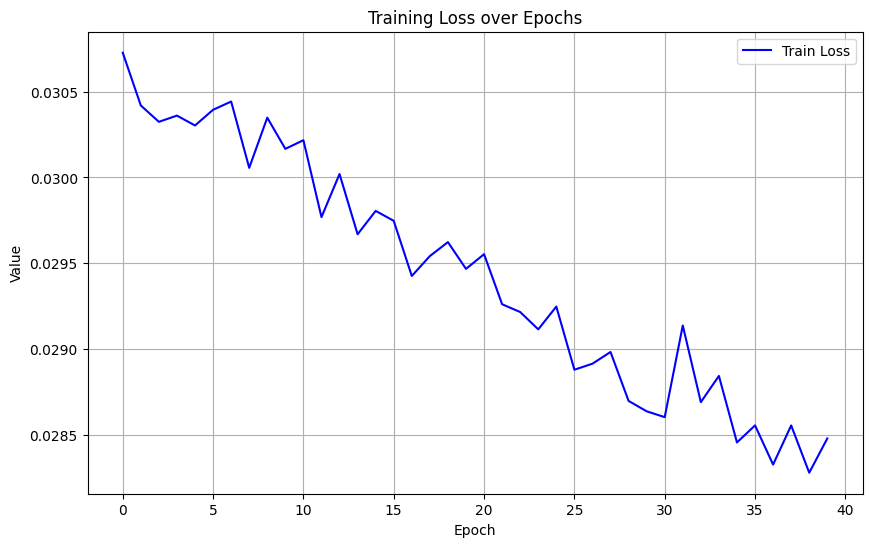

In [31]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')

# Adding titles and labels
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
# Show the plot
plt.show()